In [1]:
# Import libraries
from math import pi
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from lightgbm import LGBMRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler
from googletrans import Translator

In [2]:
#Loading data
PATH = "/root/competitive-data-science-predict-future-sales/"

item_category = pd.read_csv(PATH+'item_categories.csv')
sales_train = pd.read_csv(PATH+'sales_train.csv')
sample = pd.read_csv(PATH+"sample_submission.csv")
shops = pd.read_csv(PATH+"shops.csv")
test = pd.read_csv(PATH+"test.csv")
items = pd.read_csv(PATH+"items.csv")

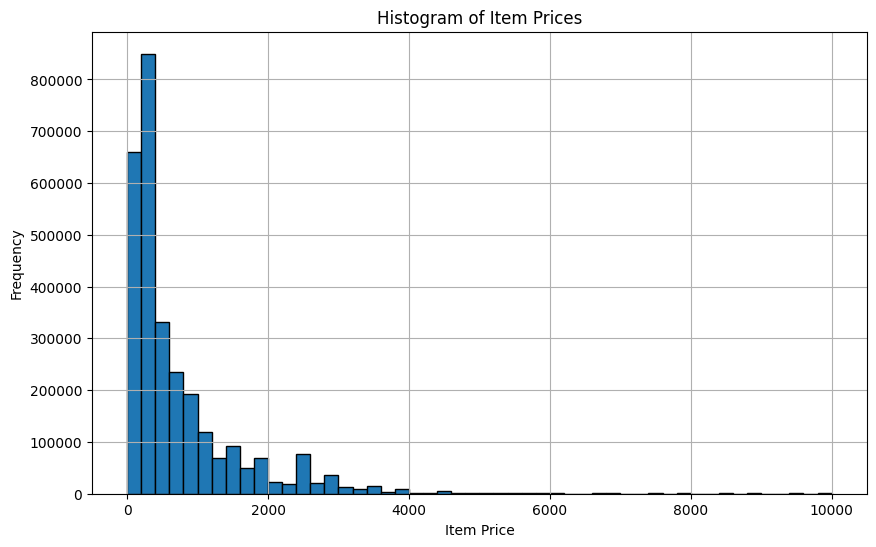

In [3]:
#Display of price range histogram for products
plt.figure(figsize=(10, 6))
plt.hist(sales_train['item_price'], bins=50, range=(0, 10000), edgecolor='black')
plt.title('Histogram of Item Prices')
plt.xlabel('Item Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

<Axes: xlabel='item_price'>

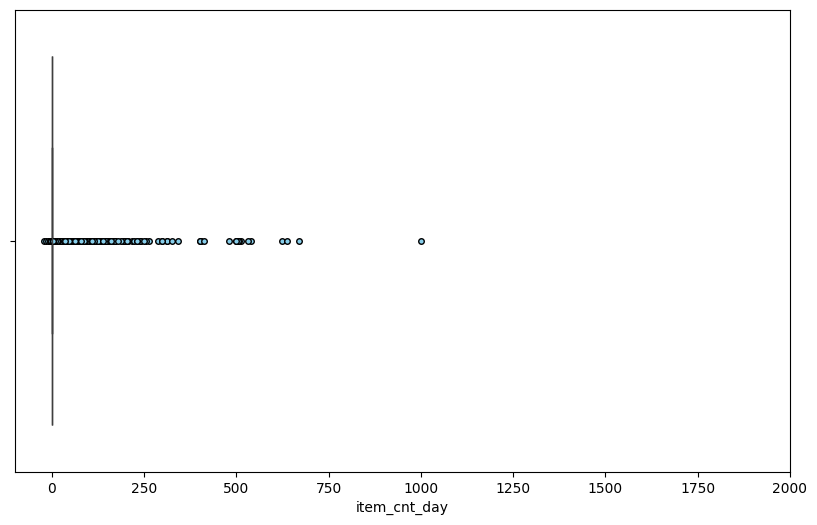

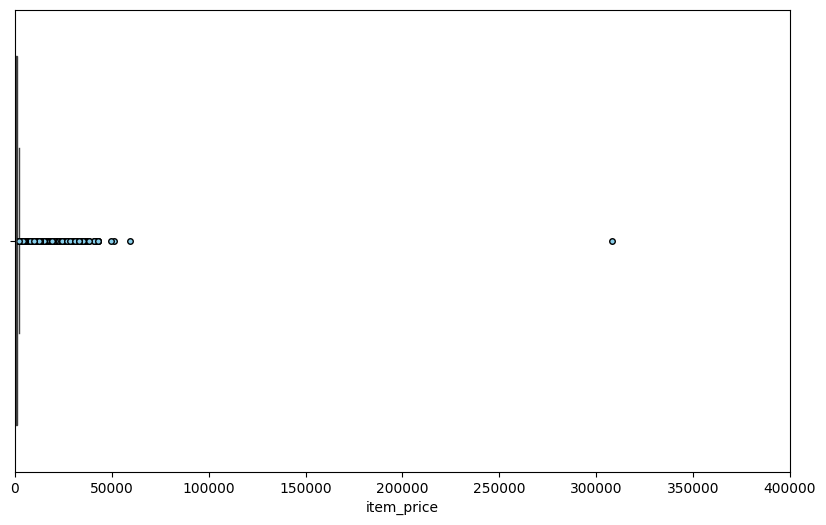

In [4]:
#Removing outliers
plt.figure(figsize=(10,6))
plt.xlim(-100,2000)
flierprops = dict(marker='o', markerfacecolor='skyblue', markersize=4,
                  linestyle='none', markeredgecolor='black')
sns.boxplot(x=sales_train['item_cnt_day'], flierprops=flierprops)

plt.figure(figsize=(10,6))
plt.xlim(-50,4e5)
sns.boxplot(x=sales_train['item_price'], flierprops=flierprops)

In [5]:
sales_train = sales_train[(sales_train['item_price']<300000)&(sales_train['item_cnt_day']<1000)]
sales_train = sales_train[sales_train['item_price']>0].reset_index(drop=True)
sales_train['item_cnt_day'] = sales_train['item_cnt_day'].apply(lambda x: 0 if x<1 else x)
sales_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,0.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935840,10.10.2015,33,25,7409,299.00,1.0
2935841,09.10.2015,33,25,7460,299.00,1.0
2935842,14.10.2015,33,25,7459,349.00,1.0
2935843,22.10.2015,33,25,7440,299.00,1.0


In [6]:
test['date_block_num'] = 34

In [7]:
test['date'] = pd.to_datetime("2015-11")
test

,ID,shop_id,item_id,date_block_num,date
0,0,5,5037,34,2015-11-01
1,1,5,5320,34,2015-11-01
2,2,5,5233,34,2015-11-01
3,3,5,5232,34,2015-11-01
4,4,5,5268,34,2015-11-01
...,...,...,...,...,...
214195,214195,45,18454,34,2015-11-01
214196,214196,45,16188,34,2015-11-01
214197,214197,45,15757,34,2015-11-01
214198,214198,45,19648,34,2015-11-01


In [8]:
#Aggregate sales from train data by month#
sales_train['date'] = pd.to_datetime(sales_train['date'],format='%d.%m.%Y')
sales_train['date'] = sales_train['date'].dt.to_period('M')

In [9]:
monthly_sales = sales_train.groupby(['shop_id', 'item_id', 'date','date_block_num'])[['item_cnt_day','item_price']].sum().reset_index()
monthly_sales = pd.DataFrame(monthly_sales)
print(monthly_sales)

         shop_id  item_id     date  date_block_num  item_cnt_day  item_price
0              0       30  2013-02               1          31.0      2385.0
1              0       31  2013-02               1          11.0      3038.0
2              0       32  2013-01               0           6.0       884.0
3              0       32  2013-02               1          10.0      1547.0
4              0       33  2013-01               0           3.0      1041.0
...          ...      ...      ...             ...           ...         ...
1609117       59    22164  2015-04              27           2.0      1398.0
1609118       59    22164  2015-07              30           1.0       699.0
1609119       59    22167  2013-10               9           1.0       299.0
1609120       59    22167  2013-12              11           2.0       598.0
1609121       59    22167  2014-06              17           1.0       299.0

[1609122 rows x 6 columns]


In [10]:
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()

In [11]:
combined = pd.concat([monthly_sales, test], axis=0, ignore_index=True)

combined['train'] = combined.apply(lambda x: 1 if x.name < len(monthly_sales) else 0, axis=1)

In [12]:
combined

,shop_id,item_id,date,date_block_num,item_cnt_day,item_price,ID,train
0,0,30,2013-02-01,1,31.0,2385.0,NaN,1
1,0,31,2013-02-01,1,11.0,3038.0,NaN,1
2,0,32,2013-01-01,0,6.0,884.0,NaN,1
3,0,32,2013-02-01,1,10.0,1547.0,NaN,1
4,0,33,2013-01-01,0,3.0,1041.0,NaN,1
...,...,...,...,...,...,...,...,...
1823317,45,18454,2015-11-01,34,NaN,NaN,214195.0,0
1823318,45,16188,2015-11-01,34,NaN,NaN,214196.0,0
1823319,45,15757,2015-11-01,34,NaN,NaN,214197.0,0
1823320,45,19648,2015-11-01,34,NaN,NaN,214198.0,0


In [13]:
#Join the shops and monthly_sales data frames to add the shop name column.
combined= pd.merge(shops, combined, on='shop_id', how='inner')
combined

,shop_name,shop_id,item_id,date,date_block_num,item_cnt_day,item_price,ID,train
0,"!Якутск Орджоникидзе, 56 фран",0,30,2013-02-01,1,31.0,2385.0,NaN,1
1,"!Якутск Орджоникидзе, 56 фран",0,31,2013-02-01,1,11.0,3038.0,NaN,1
2,"!Якутск Орджоникидзе, 56 фран",0,32,2013-01-01,0,6.0,884.0,NaN,1
3,"!Якутск Орджоникидзе, 56 фран",0,32,2013-02-01,1,10.0,1547.0,NaN,1
4,"!Якутск Орджоникидзе, 56 фран",0,33,2013-01-01,0,3.0,1041.0,NaN,1
...,...,...,...,...,...,...,...,...,...
1823317,"Ярославль ТЦ ""Альтаир""",59,18454,2015-11-01,34,NaN,NaN,152995.0,0
1823318,"Ярославль ТЦ ""Альтаир""",59,16188,2015-11-01,34,NaN,NaN,152996.0,0
1823319,"Ярославль ТЦ ""Альтаир""",59,15757,2015-11-01,34,NaN,NaN,152997.0,0
1823320,"Ярославль ТЦ ""Альтаир""",59,19648,2015-11-01,34,NaN,NaN,152998.0,0


In [14]:
#Obtaining features from date information
def day_enginnering(df):
     df['year'] = df['date'].dt.year
     df['month'] = df['date'].dt.month
     df['sin_month'] = np.sin(2 * pi * df['month'] / 12)
     df['cos_month'] = np.cos(2 * pi * df['month'] / 12)

In [15]:
day_enginnering(combined)

In [16]:
#Cleansing shop_name
combined['shop_city'] = combined['shop_name'].apply(lambda x: str(x).split(' ')[0])
combined['shop_category'] = combined['shop_name'].apply(lambda x: str(x).split(' ')[1])
combined

,shop_name,shop_id,item_id,date,date_block_num,item_cnt_day,item_price,ID,train,year,month,sin_month,cos_month,shop_city,shop_category
0,"!Якутск Орджоникидзе, 56 фран",0,30,2013-02-01,1,31.0,2385.0,NaN,1,2013,2,0.866025,0.500000,!Якутск,"Орджоникидзе,"
1,"!Якутск Орджоникидзе, 56 фран",0,31,2013-02-01,1,11.0,3038.0,NaN,1,2013,2,0.866025,0.500000,!Якутск,"Орджоникидзе,"
2,"!Якутск Орджоникидзе, 56 фран",0,32,2013-01-01,0,6.0,884.0,NaN,1,2013,1,0.500000,0.866025,!Якутск,"Орджоникидзе,"
3,"!Якутск Орджоникидзе, 56 фран",0,32,2013-02-01,1,10.0,1547.0,NaN,1,2013,2,0.866025,0.500000,!Якутск,"Орджоникидзе,"
4,"!Якутск Орджоникидзе, 56 фран",0,33,2013-01-01,0,3.0,1041.0,NaN,1,2013,1,0.500000,0.866025,!Якутск,"Орджоникидзе,"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1823317,"Ярославль ТЦ ""Альтаир""",59,18454,2015-11-01,34,NaN,NaN,152995.0,0,2015,11,-0.500000,0.866025,Ярославль,ТЦ
1823318,"Ярославль ТЦ ""Альтаир""",59,16188,2015-11-01,34,NaN,NaN,152996.0,0,2015,11,-0.500000,0.866025,Ярославль,ТЦ
1823319,"Ярославль ТЦ ""Альтаир""",59,15757,2015-11-01,34,NaN,NaN,152997.0,0,2015,11,-0.500000,0.866025,Ярославль,ТЦ
1823320,"Ярославль ТЦ ""Альтаир""",59,19648,2015-11-01,34,NaN,NaN,152998.0,0,2015,11,-0.500000,0.866025,Ярославль,ТЦ


In [17]:
encoder = OrdinalEncoder()
combined[['shop_city','shop_category']] = encoder.fit_transform(combined[['shop_city','shop_category']])
combined = combined.drop(columns='shop_name')

In [18]:
combined = pd.merge(combined, items, on='item_id', how='inner')
combined

,shop_id,item_id,date,date_block_num,item_cnt_day,item_price,ID,train,year,month,sin_month,cos_month,shop_city,shop_category,item_name,item_category_id
0,0,30,2013-02-01,1,31.0,2385.0,NaN,1,2013,2,0.866025,0.500000,0.0,4.0,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40
1,0,31,2013-02-01,1,11.0,3038.0,NaN,1,2013,2,0.866025,0.500000,0.0,4.0,007: КООРДИНАТЫ «СКАЙФОЛЛ» (BD),37
2,0,32,2013-01-01,0,6.0,884.0,NaN,1,2013,1,0.500000,0.866025,0.0,4.0,1+1,40
3,0,32,2013-02-01,1,10.0,1547.0,NaN,1,2013,2,0.866025,0.500000,0.0,4.0,1+1,40
4,0,33,2013-01-01,0,3.0,1041.0,NaN,1,2013,1,0.500000,0.866025,0.0,4.0,1+1 (BD),37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1823317,59,18454,2015-11-01,34,NaN,NaN,152995.0,0,2015,11,-0.500000,0.866025,31.0,9.0,СБ. Союз 55,55
1823318,59,16188,2015-11-01,34,NaN,NaN,152996.0,0,2015,11,-0.500000,0.866025,31.0,9.0,Настольная игра Нано Кёрлинг,64
1823319,59,15757,2015-11-01,34,NaN,NaN,152997.0,0,2015,11,-0.500000,0.866025,31.0,9.0,НОВИКОВ АЛЕКСАНДР Новая коллекция,55
1823320,59,19648,2015-11-01,34,NaN,NaN,152998.0,0,2015,11,-0.500000,0.866025,31.0,9.0,ТЕРЕМ - ТЕРЕМОК сб.м/ф (Регион),40


In [19]:
combined = pd.merge(combined, item_category, on='item_category_id', how='inner')
combined.head()

,shop_id,item_id,date,date_block_num,item_cnt_day,item_price,ID,train,year,month,sin_month,cos_month,shop_city,shop_category,item_name,item_category_id,item_category_name
0,0,30,2013-02-01,1,31.0,2385.0,NaN,1,2013,2,0.866025,0.500000,0.0,4.0,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,Кино - DVD
1,0,31,2013-02-01,1,11.0,3038.0,NaN,1,2013,2,0.866025,0.500000,0.0,4.0,007: КООРДИНАТЫ «СКАЙФОЛЛ» (BD),37,Кино - Blu-Ray
2,0,32,2013-01-01,0,6.0,884.0,NaN,1,2013,1,0.500000,0.866025,0.0,4.0,1+1,40,Кино - DVD
3,0,32,2013-02-01,1,10.0,1547.0,NaN,1,2013,2,0.866025,0.500000,0.0,4.0,1+1,40,Кино - DVD
4,0,33,2013-01-01,0,3.0,1041.0,NaN,1,2013,1,0.500000,0.866025,0.0,4.0,1+1 (BD),37,Кино - Blu-Ray


In [20]:
#Cleansing item_category_name
combined['item_category_type'] = combined['item_category_name'].apply(lambda x: str(x).split(' ')[0])
combined['split'] = combined['item_category_name'].apply(lambda x: str(x).split('-'))
combined['item_category_split_type'] = combined['split'].apply(lambda x: x[1].strip() if len(x)>1 else x[0].strip())

In [21]:
encoder = OrdinalEncoder()
combined[['item_category_type','item_category_split_type']] = encoder.fit_transform(combined[['item_category_type','item_category_split_type']])
combined = combined.drop(columns='item_category_name')

In [22]:
for column in ['shop_id', 'item_id', 'item_category_id']:
    combined[column] = combined[column].astype('category').cat.codes

In [23]:
#Creating a lag variable
def lag_creating(df, lags, column):
    tmp = df[['date_block_num', 'shop_id', 'item_id', column]]
    for i in lags:
        shift = tmp.copy()
        shift.columns = ['date_block_num', 'shop_id', 'item_id', column + '_lag_' + str(i)]
        shift['date_block_num'] += i
        df = pd.merge(df, shift, on=['date_block_num', 'shop_id', 'item_id'], how='left')
    return df

In [24]:
combined = lag_creating(combined, [1, 3, 6, 12], 'item_cnt_day')


In [25]:
combined.columns

Index(['shop_id', 'item_id', 'date', 'date_block_num', 'item_cnt_day',
       'item_price', 'ID', 'train', 'year', 'month', 'sin_month', 'cos_month',
       'shop_city', 'shop_category', 'item_name', 'item_category_id',
       'item_category_type', 'split', 'item_category_split_type',
       'item_cnt_day_lag_1', 'item_cnt_day_lag_3', 'item_cnt_day_lag_6',
       'item_cnt_day_lag_12'],
      dtype='object')

In [26]:
data_columns = ['date','shop_id','date_block_num', 'item_cnt_day',
       'item_price','train', 'year','sin_month', 'cos_month',
       'shop_city', 'shop_category','item_category_id',
       'item_category_type','item_category_split_type','item_cnt_day_lag_1', 'item_cnt_day_lag_3', 'item_cnt_day_lag_6',
       'item_cnt_day_lag_12']
data = combined[data_columns]

In [27]:
data

,date,shop_id,date_block_num,item_cnt_day,item_price,train,year,sin_month,cos_month,shop_city,shop_category,item_category_id,item_category_type,item_category_split_type,item_cnt_day_lag_1,item_cnt_day_lag_3,item_cnt_day_lag_6,item_cnt_day_lag_12
0,2013-02-01,0,1,31.0,2385.0,1,2013,0.866025,0.500000,0.0,4.0,40,7.0,4.0,NaN,NaN,NaN,NaN
1,2013-02-01,0,1,11.0,3038.0,1,2013,0.866025,0.500000,0.0,4.0,37,7.0,1.0,NaN,NaN,NaN,NaN
2,2013-01-01,0,0,6.0,884.0,1,2013,0.500000,0.866025,0.0,4.0,40,7.0,4.0,NaN,NaN,NaN,NaN
3,2013-02-01,0,1,10.0,1547.0,1,2013,0.866025,0.500000,0.0,4.0,40,7.0,4.0,6.0,NaN,NaN,NaN
4,2013-01-01,0,0,3.0,1041.0,1,2013,0.500000,0.866025,0.0,4.0,37,7.0,1.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1823317,2015-11-01,59,34,NaN,NaN,0,2015,-0.500000,0.866025,31.0,9.0,55,9.0,2.0,NaN,NaN,NaN,NaN
1823318,2015-11-01,59,34,NaN,NaN,0,2015,-0.500000,0.866025,31.0,9.0,64,10.0,42.0,NaN,NaN,NaN,NaN
1823319,2015-11-01,59,34,NaN,NaN,0,2015,-0.500000,0.866025,31.0,9.0,55,9.0,2.0,1.0,NaN,NaN,1.0
1823320,2015-11-01,59,34,NaN,NaN,0,2015,-0.500000,0.866025,31.0,9.0,40,7.0,4.0,NaN,NaN,NaN,NaN


In [28]:
train_df = data[data['train'] == 1].reset_index()
test_df = data[data['train'] == 0].reset_index()

In [29]:
#Split into train and test again
train_df = train_df.sort_values(by='date', ascending=True)
train_size = int(len(train_df) * 0.8)
train_dataset = train_df.iloc[:train_size]
valid_dataset = train_df.iloc[train_size:]

In [30]:
X_train = train_dataset.drop(columns=['index','date','item_cnt_day','train'])
y_train = train_dataset['item_cnt_day']
X_valid = valid_dataset.drop(columns=['index','date','item_cnt_day','train'])
y_valid = valid_dataset['item_cnt_day']

In [31]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

In [32]:
categorical_features = ['shop_id','item_category_id','shop_city','shop_category','item_category_id','item_category_type','item_category_sub_type']
dtrain = lgb.Dataset(X_train, label=y_train)
dval = lgb.Dataset(X_valid, label=y_valid)

In [33]:
params = {'objective': 'regression',
          'metric': 'rmse',
          'boosting_type': 'gbdt',
          'num_leaves': 31,
          'learning_rate': 0.05,
          'feature_fraction': 0.8}


lgb_model = lgb.train(params, lgb_train, valid_sets=[lgb_train, dval])

y_pred_lgb = lgb_model.predict(X_valid, num_iteration=lgb_model.best_iteration)
rmse_lgb = np.sqrt(mean_squared_error(y_valid, y_pred_lgb))
print(f'RMSE: {rmse_lgb}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 978
[LightGBM] [Info] Number of data points in the train set: 1287297, number of used features: 15
[LightGBM] [Info] Start training from score 2.305539
RMSE: 6.995639898669702


In [34]:
test_df = test_df.drop(columns=['index','date','item_cnt_day','train'])

In [35]:
y_test_pred = lgb_model.predict(test_df, num_iteration=lgb_model.best_iteration)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

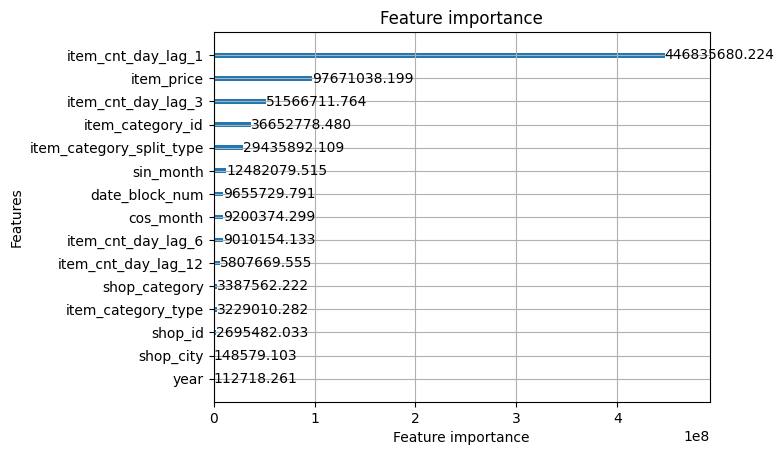

In [36]:
#Display feature_importance
lgb.plot_importance(lgb_model, importance_type="gain")